# Data Preparation

## Loading The Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf sample_data

In [3]:
!ls /content/drive/MyDrive/Data/ADNI1-1YR-1.5T/processed | grep "tar.gz" | head -n 9 | while read f; do cp /content/drive/MyDrive/Data/ADNI1-1YR-1.5T/processed/$f .; done

In [4]:
!mkdir ADNI

In [5]:
!ls . | grep processed | while read f; do tar -xf $f -C ADNI; rm $f; done;

In [ ]:
!cp /content/drive/MyDrive/Data/ADNI1-1YR-1.5T/data_groups.txt .

In [ ]:
import nibabel as nib

In [8]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted

In [9]:
def load_image_and_labels():
  import glob, re
  images = sorted(glob.glob('ADNI/**/*.nii', recursive=True))
  patients = dict(line.strip().split('\t') for line in open('data_groups.txt'))

  labels = []
  no_labels = []
  for image in images:
    subject_id = re.findall("ADNI_(\d{3}_S_\d{4})", image)[0]

    if subject_id not in patients:
      no_labels.append(image)
    else:
      labels.append(patients[subject_id])

  for image in no_labels:
    images.remove(image)

  assert len(images) == len(labels)

  return images, labels

In [10]:
images, labels = load_image_and_labels()

In [11]:
images, labels = images[:1000], labels[:1000]

## Dataset Creation

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        # img_data = img_data / 1.0 # (it's been normalized)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=3).float()
y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_encoded), num_classes=3).float()

# # Define transformations if needed
# transform = transforms.Compose([
#     # Add your transformations here if needed
# ])

# Create custom datasets
train_dataset = CustomDataset(file_paths=X_train, labels=y_train_one_hot)
test_dataset = CustomDataset(file_paths=X_test, labels=y_test_one_hot)

# Create data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [13]:
len(train_dataset)

800

In [14]:
len(test_dataset)

200

200

# Autoencoder

## Define Classes

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
class Auto3dCNN(nn.Module):
    def __init__(self):
        super(Auto3dCNN, self).__init__()

        self.d_conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 91 x 91 x 109

        self.d_conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 45 x 45 x 54

        self.d_conv3 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 22 x 22 x 27

        self.d_conv4 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 11 x 11 x 13

        self.d_conv5 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 5 x 5 x 6

        self.u_pool5 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 11 x 11 x 13
        self.u_conv5 = nn.ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool4 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 22 x 22 x 27
        self.u_conv4 = nn.ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 45 x 45 x 54
        self.u_conv3 = nn.ConvTranspose3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 91 x 91 x 109
        self.u_conv2 = nn.ConvTranspose3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 192 x 192 x 218
        self.u_conv1 = nn.ConvTranspose3d(4, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

    def forward(self, x):
        shp1 = x.shape
        x, ind1 = self.d_pool1(F.relu(self.d_conv1(x)))
        shp2 = x.shape
        x, ind2 = self.d_pool2(F.relu(self.d_conv2(x)))
        shp3 = x.shape
        x, ind3 = self.d_pool3(F.relu(self.d_conv3(x)))
        shp4 = x.shape
        x, ind4 = self.d_pool4(F.relu(self.d_conv4(x)))
        shp5 = x.shape
        x, ind5 = self.d_pool5(F.relu(self.d_conv5(x)))

        x = F.relu(self.u_conv5(self.u_pool5(x, ind5, shp5)))
        x = F.relu(self.u_conv4(self.u_pool4(x, ind4, shp4)))
        x = F.relu(self.u_conv3(self.u_pool3(x, ind3, shp3)))
        x = F.relu(self.u_conv2(self.u_pool2(x, ind2, shp2)))
        x = F.relu(self.u_conv1(self.u_pool1(x, ind1, shp1)))

        return x


class Auto3dCNN2(nn.Module):
    def __init__(self):
        super(Auto3dCNN2, self).__init__()

        self.d_conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 91 x 91 x 109

        self.d_conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 45 x 45 x 54

        self.d_conv3 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 22 x 22 x 27

        self.d_conv4 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 11 x 11 x 13

        self.d_conv5 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.d_pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True) # 5 x 5 x 6

        self.u_pool5 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 12 x 12 x 13
        self.u_conv5 = nn.ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool4 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 24 x 24 x 27
        self.u_conv4 = nn.ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 48 x 48 x 54
        self.u_conv3 = nn.ConvTranspose3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 96 x 96 x 109
        self.u_conv2 = nn.ConvTranspose3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.u_pool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) # 192 x 192 x 218
        self.u_conv1 = nn.ConvTranspose3d(4, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

    def forward(self, x):
        shp1 = x.shape
        x1, ind1 = self.d_pool1(F.relu(self.d_conv1(x)))
        shp2 = x1.shape
        x2, ind2 = self.d_pool2(F.relu(self.d_conv2(x1)))
        shp3 = x2.shape
        x3, ind3 = self.d_pool3(F.relu(self.d_conv3(x2)))
        shp4 = x3.shape
        x4, ind4 = self.d_pool4(F.relu(self.d_conv4(x3)))
        shp5 = x4.shape
        x5, ind5 = self.d_pool5(F.relu(self.d_conv5(x4)))

        y4 = F.relu(self.u_conv5(self.u_pool5(x5, ind5, shp5)) + x4)
        y3 = F.relu(self.u_conv4(self.u_pool4(y4, ind4, shp4)) + x3)
        y2 = F.relu(self.u_conv3(self.u_pool3(y3, ind3, shp3)) + x2)
        y1 = F.relu(self.u_conv2(self.u_pool2(y2, ind2, shp2)) + x1)
        y = F.tanh(self.u_conv1(self.u_pool1(y1, ind1, shp1)) + x)

        return y


class Auto3dCNN3(nn.Module):
    def __init__(self):
        super(Auto3dCNN3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True),
            nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), return_indices=True)
        )

        self.decoder = nn.Sequential(
            nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.ConvTranspose3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.ConvTranspose3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.ConvTranspose3d(4, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )

    def forward(self, x):
        x1, ind1 = self.encoder[1](F.relu(self.encoder[0](x)))
        x2, ind2 = self.encoder[3](F.relu(self.encoder[2](x1)))
        x3, ind3 = self.encoder[5](F.relu(self.encoder[4](x2)))
        x4, ind4 = self.encoder[7](F.relu(self.encoder[6](x3)))
        x5, ind5 = self.encoder[9](F.relu(self.encoder[8](x4)))

        y4 = F.relu(self.decoder[1](self.decoder[0](x5, ind5, x4.shape)) + x4)
        y3 = F.relu(self.decoder[3](self.decoder[2](y4, ind4, x3.shape)) + x3)
        y2 = F.relu(self.decoder[5](self.decoder[4](y3, ind3, x2.shape)) + x2)
        y1 = F.relu(self.decoder[7](self.decoder[6](y2, ind2, x1.shape)) + x1)
        y = F.tanh(self.decoder[9](self.decoder[8](y1, ind1, x.shape)) + x)

        return y


class Auto3dCNN4(nn.Module):
    def __init__(self, input_size=(182, 182, 218), depth=5):
        super(Auto3dCNN4, self).__init__()

        output_size = list(input_size)
        self.sizes = [output_size]
        for _ in range(depth - 2):
            layer_size = [s // 2 for s in self.sizes[-1]]
            self.sizes.append(layer_size)

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        channels_in = 1
        channels_out = 4

        for _ in range(depth - 1):
          self.encoder.append(nn.Conv3d(channels_in, channels_out, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
          self.encoder.append(nn.ReLU())
          self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
          channels_in = channels_out
          channels_out = channels_out * 2

        self.encoder.append(nn.Conv3d(channels_in, channels_out, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        temp = channels_in
        channels_in = channels_out
        channels_out = temp

        for i in range(1, depth):
          self.decoder.append(nn.ConvTranspose3d(channels_in, channels_out, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
          self.decoder.append(nn.ReLU())
          self.decoder.append(nn.Upsample(size=self.sizes[-i], mode='trilinear', align_corners=False))
          channels_in = channels_out
          channels_out = channels_out // 2

        self.decoder.append(nn.Conv3d(channels_in, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        # x = self.encoder(x)
        # y = self.decoder(x)

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1

        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)

        return x

In [17]:
from torchsummary import summary

In [18]:
# model = Auto3dCNN3()
# summary(model, (1, 182, 182, 218))

## Define Utility Functions

In [19]:
import shutil
import os
import matplotlib.pyplot as plt

In [20]:
def save_checkpoint(model, optimizer, epoch, filename, train_losses, test_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    save_path = '/content/drive/MyDrive/Checkpoints'

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(model, optimizer, filename):
    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    return model, optimizer, epoch, train_losses, test_losses

In [21]:
def validate(model, dataloader):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == torch.argmax(target, dim=1)).sum().item()

  accuracy = correct / total

  model.train()
  return accuracy

def plot(losses, lables):

  assert len(losses) == len(labels)

  for (loss, label) in list(zip(losses, lables)):
    plt.plot(loss, label=label)
    plt.plot(loss, label=label)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

## Train

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
params_filename = 'checkpoint.pth'

In [ ]:
import torch

# Instantiate the model
model = Auto3dCNN4(depth=6)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=2e-3) #lr=0.001
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
# model, optimizer, s_epoch = load_checkpoint(model, optimizer, '/content/checkpoint(3).pth')
# model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint(11).pth')

# Number of training epochs
num_epochs = 15

# Training loop
for epoch in range(s_epoch + 1, num_epochs):
    model.train()  # Set the model to training mode

    epoch_train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, data)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print training statistics
        if batch_idx % 10 == 0:
            # print(torch.argmax(output, dim=1))
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

    epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode

    epoch_valid_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            epoch_valid_loss += loss.item()

    epoch_valid_loss = epoch_valid_loss / len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_valid_loss}')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)


    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch, params_filename, train_losses, valid_losses)
        # train_accuracy = validate(model, train_loader)
        # print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

Epoch 1/15, Batch 1/50, Loss: 0.02529641054570675
Epoch 1/15, Batch 11/50, Loss: 0.0208993311971426
Epoch 1/15, Batch 21/50, Loss: 0.01450160052627325
Epoch 1/15, Batch 31/50, Loss: 0.008501224219799042
Epoch 1/15, Batch 41/50, Loss: 0.0062796324491500854
Epoch 1/15, Validation Loss: 0.005372642966297765
Epoch 2/15, Batch 1/50, Loss: 0.005388210527598858
Epoch 2/15, Batch 11/50, Loss: 0.004655910190194845
Epoch 2/15, Batch 21/50, Loss: 0.0039365882985293865
Epoch 2/15, Batch 31/50, Loss: 0.0034688408486545086
Epoch 2/15, Batch 41/50, Loss: 0.0027100001461803913
Epoch 2/15, Validation Loss: 0.0024624086023929217
Epoch 3/15, Batch 1/50, Loss: 0.002430911408737302
Epoch 3/15, Batch 11/50, Loss: 0.0020068218000233173
Epoch 3/15, Batch 21/50, Loss: 0.001798145705834031
Epoch 3/15, Batch 31/50, Loss: 0.0017098459647968411
Epoch 3/15, Batch 41/50, Loss: 0.001679695793427527
Epoch 3/15, Validation Loss: 0.0012805927738857765
Epoch 4/15, Batch 1/50, Loss: 0.0012788830790668726
Epoch 4/15, Batch

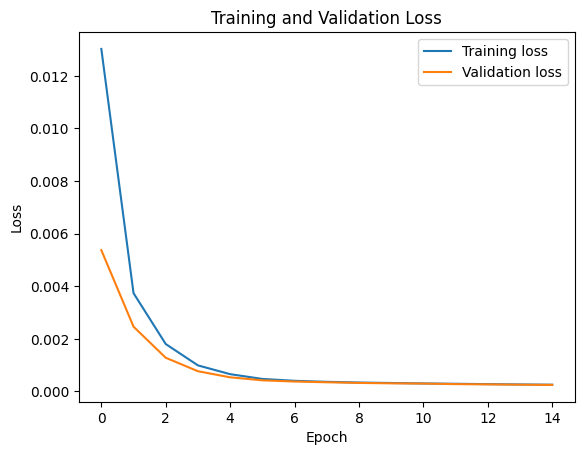

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Plot

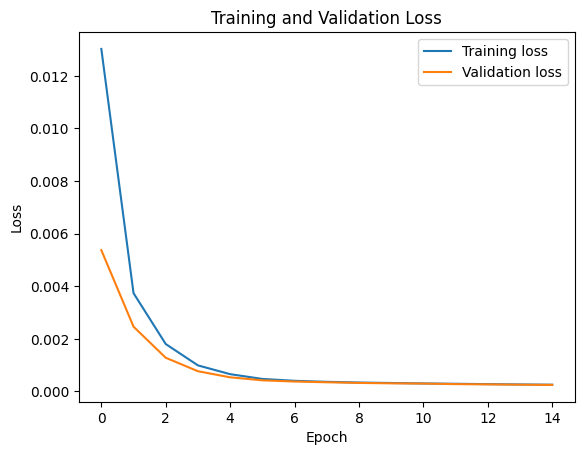

In [22]:
import torch

# Instantiate the model
model = Auto3dCNN4(depth=6)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/autoencoder-d6-skip.pth')

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Save Reconstructed Image

In [ ]:
data, target = next(iter(train_loader))

In [ ]:
data = data.to(device)

In [ ]:
data = data[0].unsqueeze(0)

In [ ]:
model.to(device)
output = model(data)

In [ ]:
temp = output[0].squeeze(0)

In [ ]:
temp2 = temp.permute(1,2,0)

In [ ]:
temp3 = temp2.detach().cpu().numpy()

In [ ]:
new_image = nib.Nifti1Image(temp3, affine=np.eye(4))

In [ ]:
nib.save(new_image, 'reconstructed_image.nii')

# Classifier

## Define

In [23]:
class EncoderClassifier(nn.Module):
  def __init__(self, encoder, input):
    super(EncoderClassifier, self).__init__()

    self.encoder = encoder
    self.classifier = nn.Sequential(
        # nn.BatchNorm3d(128),
        nn.Flatten(),
        # nn.Dropout(p=0.1),
        nn.Linear(input, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        # nn.Dropout(p=0.05),
        nn.Linear(8, 3),
        nn.Softmax(dim=1)
    )

    for param in self.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):

    x = self.encoder(x)
    y = self.classifier(x)

    return y

In [24]:
import functools
import operator
depth = 6
input_shape = [d // (2**(depth-1)) for d in [182, 182, 218]]
input_shape.append(2**(depth+1))
input_pixels = functools.reduce(operator.mul, input_shape)

In [ ]:
from torchsummary import summary
classifier = EncoderClassifier(model.encoder, input_pixels).cuda()
summary(classifier, (1, 182, 182, 218))

In [ ]:
classifier.encoder

## Train

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
params_filename = 'checkpoint.pth'

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
input = input_pixels

# Instantiate the model
classifier = EncoderClassifier(model.encoder, input)
classifier.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
optimizer = optim.SGD(classifier.parameters(), lr=2e-4) #lr=0.001
# optimizer = optim.AdamW(classifier.parameters(), lr=1e-4) #lr=0.001

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
# model, optimizer, s_epoch = load_checkpoint(model, optimizer, '/content/checkpoint(3).pth')
# model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint(8).pth')

# Number of training epochs
num_epochs = 30

# Training loop
for epoch in range(s_epoch + 1, num_epochs):
    classifier.train()  # Set the classifier to training mode

    epoch_train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = classifier(data)

        # Calculate the loss
        loss = criterion(output, torch.argmax(target, dim=1))
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()
        # print(classifier.fc2.weight.grad)

        # Update weights
        optimizer.step()

        # Print training statistics
        if batch_idx % 10 == 0:
            print(torch.argmax(output, dim=1))
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

    epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation loop
    classifier.eval()  # Set the classifier to evaluation mode
    correct = 0
    total = 0

    epoch_valid_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()
            loss = criterion(output, torch.argmax(target, dim=1))
            epoch_valid_loss += loss.item()

    epoch_valid_loss = epoch_valid_loss / len(test_loader)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    valid_accuracy.append(accuracy)


    if (epoch + 1) % 5 == 0:
        save_checkpoint(classifier, optimizer, epoch, params_filename, train_losses, valid_losses)
        train_accuracy = validate(classifier, train_loader)
        print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
Epoch 1/30, Batch 1/50, Loss: 1.1284490823745728
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Epoch 1/30, Batch 11/50, Loss: 1.1048449277877808
tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
Epoch 1/30, Batch 21/50, Loss: 1.103995442390442
tensor([0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Epoch 1/30, Batch 31/50, Loss: 1.127591848373413
tensor([0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Epoch 1/30, Batch 41/50, Loss: 1.1312905550003052
Validation Accuracy: 20.31%
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2], device='cuda:0')
Epoch 2/30, Batch 1/50, Loss: 1.0851819515228271
tensor([0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1], device='cuda:0')
Epoch 2/30, Batch 11/50, Loss: 1.1235932111740112
tensor([0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0], device='cuda:0')
Epoch 2/30, Batch 21/50, Loss: 1.1

In [ ]:
classifier.parameters()

<generator object Module.parameters at 0x7f7b08a7da80>

## Plot